In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [58]:
# plots of predictions path
save_dir_predictions = "BTC Prices Forecasting"
# plots of sectorial importances path
save_dir_sectors_importances = "Sectors Importance Prices Forecasting"
# plots of features importances path
save_dir_features_importances = "Features Importance Prices Forecasting"

os.makedirs(save_dir_predictions, exist_ok=True)
os.makedirs(save_dir_sectors_importances, exist_ok=True)
os.makedirs(save_dir_features_importances, exist_ok=True)

btc=pd.read_excel("btc.xlsx")
all_data=[]
all_data.append(btc)

# Define start and end dates for the weekly data
start_date = pd.to_datetime('09/01/2011')  # Adjusted for weekly data
end_date = pd.to_datetime('24/12/2023')    # Adjusted for weekly data

# Filter btc data for the specified weekly date range
btc_range = btc[(btc['Date'] >= start_date) & (btc['Date'] <= end_date)]
btc = btc_range.reset_index(drop=True)  # Reset index without inplace=True
all_data[0] = btc.copy()  # Assign a copy of btc to all_data[0]

In [ ]:
all_data_ticker=['AMAZON', 'APPLE', 'google', 'TESLA',
                 'GOLD', 'CL1 COMB Comdty', 'NG1 COMB Comdty', 'CO1 COMB Comdty', 
                 'DowJones', 'Nasdaq', 'S&P', 'Cac40', 'ftse', 'NKY',
                 'EURR002W', 'DEYC2Y10', 'USYC2Y10', 'JPYC2Y10', 'TED SPREAD JPN', 'TED SPREAD US', 'TED SPREAD EUR',
                 'renminbiusd', 'yenusd', 'eurodollar' ,'gbpusd',
                 'active_address_count', 'addr_cnt_bal_sup_10K', 'addr_cnt_bal_sup_100K' , 'miner-revenue-native-unit','miner-revenue-USD','mvrv','nvt','tx-fees-btc', 'tx-fees-usd']
                
                 
                 
    

all_data_name=['Amazon', 'Apple','Google', 'Tesla',
               'Gold', 'WTI Crude Future', 'Natural Gas Future', 'Brent Crude Future',
               'DowJones', 'Nasdaq', 'S&P', 'Cac40', 'FTSE', 'Nikkei', 
               'ECB Policy Rates', 'Yield Curve Germany', 'Yield Curve US', 'Yield Curve Japan', 'TED Spread Japan', 'TED Spread US','TED Spread Europe'
               'Renminbi/Dollar', 'Yen/Dollar', 'Euro/Dollar', 'Gbp/Dollar',
               'Active Addresses', 'addr_cnt_bal_sup_10K', 'addr_cnt_bal_sup_100K', 'miner-revenue-native-unit', 'miner-revenue-USD', 'mvrv', 'nvt', 'tx-fees-btc', 'tx-fees-usd']
               
               
               


for ticker in all_data_ticker:
    all_data.append(pd.read_excel(ticker + ".xlsx"))

In [ ]:
# Keeping only the date and 'raw datas' --> mostly prices 
keep_columns=['Date','Dernier Prix']

# Iterate through all_data and keep only the specified columns
for element in all_data:
    element = element[keep_columns]
# Iterate through all_data and preprocess each element
for i, element in enumerate(all_data):
    element = element[keep_columns].copy()  # Copy the selected columns
    element['Date'] = pd.to_datetime(element['Date'])  # Convert 'Date' column to datetime
    # Drop rows with 'Date' values earlier than start_date
    element.drop(element[element['Date'] < start_date].index, inplace=True)
    all_data[i] = element  # Update all_data with preprocessed element

# Find common dates among all datasets
common_dates_all = set(btc['Date'])
lenmax = len(btc)

# Preprocess each dataset to keep only common dates
for i, element in enumerate(all_data):
    common_dates_all = common_dates_all.intersection(set(element['Date']))
    element = element[element['Date'].isin(common_dates_all)].copy()
    all_data[i] = element
    common_dates_all = set(btc['Date'])  # Reset common_dates_all to original btc dates

# Create DataFrame with all unique dates from btc dataset
all_dates = pd.DataFrame({'Date': pd.to_datetime(btc['Date'])})

# Merge all_dates with dates from other datasets (take into account that all our weekly datasets are indexed with the same dates)
for dataset in all_data[1:]:
    all_dates = pd.merge(all_dates, dataset[['Date']], on='Date', how='left')

# Fill missing values in datasets based on all_dates
all_datasets_filled = []
all_datasets_filled.append(btc)  # Append original btc dataset
for dataset in all_data[1:]:
    dataset_filled = pd.merge(all_dates, dataset, on='Date', how='left')  # Merge with all_dates
    dataset_filled = dataset_filled.fillna(method='ffill')  # Fill missing values with forward fill
    all_datasets_filled.append(dataset_filled)  # Append filled dataset to all_datasets_filled
    
all_data_ticker=['btc', 'AMAZON', 'APPLE', 'google', 'TESLA',
                 'GOLD', 'CL1 COMB Comdty', 'NG1 COMB Comdty', 'CO1 COMB Comdty', 
                 'DowJones', 'Nasdaq', 'S&P', 'Cac40', 'ftse', 'NKY',
                 'EURR002W', 'DEYC2Y10', 'USYC2Y10', 'JPYC2Y10', 'TED SPREAD JPN', 'TED SPREAD US', 'TED SPREAD EUR',
                 'renminbiusd', 'yenusd', 'eurodollar' ,'gbpusd',
                 'active_address_count', 'addr_cnt_bal_sup_10K', 'addr_cnt_bal_sup_100K' , 'miner-revenue-native-unit','miner-revenue-USD','mvrv','nvt','tx-fees-btc', 'tx-fees-usd']
                
    
# Check if the number of tickers matches the number of DataFrames
if len(all_data_ticker) != len(all_datasets_filled):
    raise ValueError("Number of tickers and number of DataFrames do not match.")

# Assign unique names to columns based on tickers
for i, (df, ticker) in enumerate(zip(all_datasets_filled, all_data_ticker)):
    df.columns = [f"{ticker}_{col}" if col != "Date" else "Date" for col in df.columns]

# Concatenate DataFrames horizontally
merged_df = pd.concat(all_datasets_filled, axis=1)
merged_df=pd.DataFrame(merged_df)

# Extracting columns containing dates and data
data_columns = merged_df.iloc[0:, 1::2]  # Selecting every features columns
dates_columns = merged_df.iloc[0:, 0] # Selecting one date columns

# Creating a DataFrame with only dates and data columns
dataset_prices = pd.concat([dates_columns, data_columns], axis=1)
dataset_prices = pd.DataFrame(dataset_prices)

# Ensure 'Date' column is in datetime format
dataset_prices['Date'] = pd.to_datetime(dataset_prices['Date'])

# Sort DataFrame by the 'Date' column in ascending order
dataset_prices = dataset_prices.sort_values(by='Date')

# Resetting index after sorting
dataset_prices = dataset_prices.reset_index(drop=True)

# Filling missing values by propagating last valid observation forward
dataset_prices = dataset_prices.ffill(axis=1)

# Setting 'Date' column as index
dataset_prices['Date'] = pd.to_datetime(dataset_prices['Date'])
dataset_prices.set_index('Date', inplace=True)

In [ ]:
def calculate_returns(df):
    
    # Ensure the DataFrame has a DateTimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex for time series data.")

    # Convert columns to numeric (excluding the 'Date' column)
    numeric_cols = df.columns.difference(['Date'])
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Exclude the first row and calculate daily returns for each column
    returns_df = pd.DataFrame(index=df.index)  # Create an empty DataFrame with the same index
    for col in numeric_cols:
        # Calculate returns: (current value / previous value) - 1
        returns_df[col + '_returns'] = (df[col] / df[col].shift(1) - 1).replace([np.inf, -np.inf, np.nan], 0)

    return returns_df


# VOLATILITY (Standard Deviation of a rolling specified window)

def calculate_volatility(df, window):
 
    # Convert columns to numeric (excluding the 'Date' column)
    numeric_cols = df.columns.difference(['Date'])
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Exclude the first row and calculate volatility for each column using rolling window
    volatility_df = pd.DataFrame(index=df.index)  # Create an empty DataFrame with the same index
    for col in numeric_cols:
        # Calculate volatility using rolling standard deviation
        volatility_df[col + '_volatility'] = df[col].rolling(window=window).std()    

    # Replace infinite values with NaN and fill NaN with 0
    volatility_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    volatility_df.fillna(0, inplace=True)

    return volatility_df

# Normalized returns (returns / volatility) in order to introduce the volatilities' information to our further analysis

def calculate_z_score(returns_df, volatility_df, prices_df):
    
    # Convert columns to numeric (excluding the 'Date' column)
    numeric_cols = prices_df.columns.difference(['Date'])
    prices_df[numeric_cols] = prices_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Calculate z-scores for each column
    z_score_df = pd.DataFrame(index=prices_df.index)  # Create an empty DataFrame with the same index
    for col in numeric_cols:
        # Calculate z-score: returns / volatility
        z_score_df[col + '_z_score'] = returns_df[col + '_returns'] / volatility_df[col + '_volatility']
    
    # Replace infinite values with NaN and fill NaN with 0
    z_score_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    z_score_df.fillna(0, inplace=True)

    return z_score_df

def average(lst):
    if len(lst) == 0:
        return 0  # Handle the case where the list is empty to avoid division by zero
    total = sum(lst)
    return total / len(lst)


In [ ]:
# Dataset containing returns
dataset_returns = calculate_returns(dataset_prices)

# Dataset containing rolling MONTHLY volatility
dataset_volatility=calculate_volatility(dataset_prices, 4) # window of 4 weeks chosen

# Dataset containing normalized returns (divided by their volatility)
dataset_z_score = calculate_z_score(dataset_returns, dataset_volatility, dataset_prices)

# DataFrame with Prices, Returns and Volatilities (non-stationary)
dataset_prices_returns=pd.concat([dataset_prices, dataset_returns], axis=1)
dataset_prices_returns_volatility=pd.concat([dataset_prices_returns, dataset_volatility], axis=1)
dataset_prices_returns_volatility=pd.DataFrame(dataset_prices_returns_volatility)

# DataFrame with Returns and Normalized returns (stationary)
dataset_returns_zscores=pd.concat([dataset_returns, dataset_z_score], axis=1)
dataset_returns_zscores=pd.DataFrame(dataset_returns_zscores)

In [ ]:
# ADF Tests

def adf_test_for_all_features(df):
    """
    Perform Augmented Dickey-Fuller test for stationarity for all features in a DataFrame.
    
    Args:
    - df (pd.DataFrame): The DataFrame containing multiple columns of time series data to be tested.
    
    Returns:
    - stationary_series (list): A list containing names of stationary series.
    - non_stationary_series (list): A list containing names of non-stationary series.
    """
  
    # Iterate over each column in the DataFrame
    for col in df.columns:
        # Perform ADF test for the current column
        result = adfuller(df[col])
        p_value = result[1]
        
        # Determine if the series is stationary based on p-value
        if p_value <= 0.05:
            print("Stationary -> ", col)
        else:
            print("Non Stationary -> ", col)



adf_test_for_all_features(dataset_prices_returns_volatility)


### Correaltion between all the features 

In [ ]:
# Dataset choice (note that the dataset chosen must be stationary):
    
# dataset_prices
# dataset_returns
# dataset_volatility
# dataset_z_score
# dataset_prices_returns_volatility
# dataset_returns_zscores

correlation_matrix = dataset_returns.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(60, 60))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=.5, linecolor = 'white' )
plt.title('Correlation matrix of the WEEKLY features')
plt.show()

In [ ]:
# As we are working with stationary and non stationary datas to predict BTC price.
# I will use the dataset : dataset_prices_returns_volatility
# Which contains raw datas, returns and volatilities                              

# Droping labels containing the BTC features (prices, returns, volatilities)
features1 = dataset_prices_returns_volatility.drop("btc_Dernier Prix", axis=1)
features2 = features1.drop("btc_Dernier Prix_returns", axis=1)
features = features2.drop("btc_Dernier Prix_volatility", axis=1)

labels = dataset_prices_returns_volatility["btc_Dernier Prix"]

### Grid Search with cross-validation

# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [25, 50, 100 ],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=1,
    n_jobs=-1 
)

grid_search.fit(features, labels)

best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [25, 50, 100, 200],  
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100,  
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)


random_search.fit(features, labels)  
print("Best Hyperparameters:", random_search.best_params_)

### Random Forest with best hyperparameters 

In [ ]:
# Basically, I chose a 200 weeks window analysis. Which is representative to a Bitcoin cycle period.
# I take 160 weeks to TRAIN my model and 40 weeks to TEST it.
# Then I make my Random Forest predictions on the price of Bitcoin and iterate with a 4 weeks rolling.
# I chose to make a rolling incrementation instead of an expanding one in order to keep only 
# the dynamics that might explain the Bitcoin's narratives (features that explain Bitcoin are evolving with time !)


all_total_prices = []
bitcoin_prices = []
accuracy_values = []
group_importances_mean = []


for i in range(0, len(labels)-200, 4):
 
    train_labels=labels.iloc[0+i:160+i]
    train_features=features.iloc[0+i:160+i]

    test_labels=labels.iloc[159+i:200+i]
    test_features=features.iloc[159+i:200+i]
    
    train_dates=dataset_prices.index[0+i:160+i]
    test_dates=dataset_prices.index[159+i:200+i]


    # Instantiate model 
    rf = RandomForestRegressor(n_estimators= 25, max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=(42))

    # Train the model on training data
    rf.fit(train_features, train_labels)

    # Make Predictions on Test Data

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)

    # Calculate the absolute errors
    errors = abs(predictions - test_labels)

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    accuracy_values.append(accuracy)

    # Variable Importances

    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(list(features.columns), importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    
    feature_importances_df = pd.DataFrame(feature_importances[:10], columns=['Feature', 'Importance'])
    
    
    ####################################################################################
    #packages of features (sectorials groups)


    # Feature groups defined earlier
    feature_groups = {
        "Equity_Indices": [
            "DowJones", "Nasdaq", "S&P", "Cac40", "ftse", "NKY"
        ],
        "Individual_Stocks": [
            "AMAZON", "APPLE", "google", "TESLA"
        ],
        "Commodity_Prices": [
            "GOLD", "CL1 COMB Comdty", "NG1 COMB Comdty", "CO1 COMB Comdty"
        ],
        "Interest_Rates_Yields": [
            "USYC2Y10", "TED SPREAD EUR", "TED SPREAD US", "TED SPREAD JPN", "EURR002W", "JPYC2Y10","DEYC2Y10"
        ],
       
        "Blockchain_Cryptocurrency_Metrics": [
            "active_address_count", "addr_cnt_bal_sup_10K", "addr_cnt_bal_sup_100K", "miner-revenue-native-unit", "miner-revenue-USD", "mvrv", "nvt", "tx-fees-btc", "tx-fees-usd"
        ],
        "Foreign_Exchange_Rates": [
            "eurodollar", "gbpusd", "renminbiusd", "yenusd"
        ]
         }


    # Initialize a dictionary to hold the aggregated importances for each group
    group_importances = {group: 0 for group in feature_groups}

    # Iterate over each feature importance returned by the model
    for feature, importance in zip(features.columns, rf.feature_importances_):
        # Initialize a variable to determine if the feature was found in any group
        found_group = None
        
        # Check if the feature name contains any of the group identifiers
        for group, group_features in feature_groups.items():
            if any(group_feature in feature for group_feature in group_features):
                found_group = group
                break
        
        # Aggregate the importance to the respective group
        if found_group:
            group_importances[found_group] += importance
        else:
            print(f"Feature '{feature}' not clearly assignable to any group")

    # Sort the group importances by most important first
    sorted_group_importances = sorted(group_importances.items(), key=lambda x: x[1], reverse=True)

    # Convert to DataFrame for easier plotting
    group_importances_df = pd.DataFrame(sorted_group_importances, columns=['Group', 'Importance'])
    group_importances_mean.append(group_importances_df)
    # Define the plot title and the filename for saving the plot

   ############################################################################################## 

    all_total_prices.append(np.mean(predictions[-4:])) # KEEP THE LAST 4 predicted weekly returns --> last month returns prediction
    bitcoin_prices.append(np.mean(test_labels[-4:]))
    

all_total_returns = pd.DataFrame(all_total_prices)
bitcoin_returns = pd.DataFrame(bitcoin_prices)

### Predictions' accuracy over time 

In [ ]:
start_date_accuracy = pd.to_datetime('21/09/2014')  
end_date_accuracy = pd.to_datetime('24/12/2023')   
dates_accuracy = pd.date_range(start=start_date_accuracy, end=end_date_accuracy, freq='M')

dates_accuracy_fit = pd.to_numeric(dates_accuracy)
coefficients = np.polyfit(dates_accuracy_fit, accuracy_values, deg=1)  

dates_fit = np.linspace(min(dates_accuracy_fit), max(dates_accuracy_fit), 100)  
dates_fit_datetime = pd.to_datetime(dates_fit) 

accuracy_values_fit = np.polyval(coefficients, dates_fit)

accuracy_values_mean = average(accuracy_values)
print("Accuracy of the predicted prices with all features:", round(accuracy_values_mean,2),"%.")
print("\n\n")


plt.figure(figsize=(10, 6))
plt.scatter(dates_accuracy[:len(accuracy_values)], accuracy_values, label='Original Accuracy')
plt.plot(dates_fit_datetime[:len(accuracy_values_fit)], accuracy_values_fit, color='red', label='Accuracy Fitted Line')
plt.xlabel('Date')
plt.ylabel('Accuracy (%)')
plt.title('Curve Fitting with Linear Regression')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Group's Importance 

In [ ]:
all_groups = pd.concat(group_importances_mean)

grouped_groups_mean = all_groups.groupby('Group').mean({'Importance': 'sum'}).sort_values(by='Importance', ascending = False)

grouped_groups_mean.reset_index(inplace=True)


plt.figure(figsize=(10, 6))  
plt.pie(
    grouped_groups_mean['Importance'], 
    labels=grouped_groups_mean['Group'], 
    autopct='%1.1f%%',  
    startangle=180  
)
plt.axis('equal')  
plt.title('Average Group Importance')

plt.show()

### Evolution of the Importance of groups over time 

In [ ]:
start_date_importance = pd.to_datetime('21/09/2014')  
end_date_importance = pd.to_datetime('24/12/2023')    
dates_importance = pd.date_range(start=start_date_importance, end=end_date_importance, freq='M')

for df, date in zip(group_importances_mean, dates_importance):
    df['Date'] = pd.to_datetime(date)

all_data = pd.concat(group_importances_mean)

filtered_data = all_data[all_data['Group'].isin(['Blockchain_Cryptocurrency_Metrics', 'Equity_Indices'])]

pivot_data = filtered_data.pivot(index='Date', columns='Group', values='Importance')

plt.figure(figsize=(10, 6))
plt.plot(pivot_data) 
plt.title("Evolution of the 2 most important groups")
plt.xlabel('Date')
plt.ylabel('Importance (%)')
plt.grid(True)
plt.legend(labels = ['Blockchain_Cryptocurrency_Metrics', 'Equity_Indices'], title='Groups', bbox_to_anchor=(0.5, -0.3), loc='lower center')
plt.tight_layout()
plt.show()


### ACF and PACF model to identify SARIMA optimal parameters 

In [ ]:
btc_prices = dataset_prices['btc_Dernier Prix'].dropna()


# Plot ACF to determine q
plt.figure(figsize=(12, 6))
plot_acf(btc_prices, lags=40, ax=plt.gca())
plt.title('Autocorrelation (ACF)')
plt.show()

# Plot PACF to determine p
plt.figure(figsize=(12, 6))
plot_pacf(btc_prices, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation (PACF)')
plt.show()


### Testing the seasonality

In [ ]:
result = seasonal_decompose(btc_prices, model='additive', period=52)  
result.plot()
plt.show()

### SARIMA Model  

In [ ]:
sarima_model = SARIMAX(btc_prices, order=(2, 1, 2), seasonal_order=(2, 1, 2, 52)) # annual seasonality with weekly datas.  
sarima_result = sarima_model.fit()
forecast = sarima_result.forecast(steps=104)

### Plot of the forecasted prices 

In [ ]:
forecast_steps = 104 # 2 years of forecasts 
plt.figure(figsize=(10, 6))
plt.plot(btc_prices, label='Historical Prices')
plt.plot(pd.date_range(btc_prices.index[-1], periods=forecast_steps, freq='W'), forecast, label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

### Save paths for new predictions 

In [ ]:
# plots of predictions path
save_dir_predictions_rfe = "BTC Prices Forecasting RFE"
# plots of sectorial importances path
save_dir_sectors_importances_rfe = "Sectors Importance Prices Forecasting RFE"
# plots of features importances path
save_dir_features_importances_rfe = "Features Importance Prices Forecasting RFE"

os.makedirs(save_dir_predictions_rfe, exist_ok=True)
os.makedirs(save_dir_sectors_importances_rfe, exist_ok=True)
os.makedirs(save_dir_features_importances_rfe, exist_ok=True)


### Selection of the most explicative features using Recursive Feature Elimination

In [ ]:
features_rfe = dataset_prices.drop(columns=['btc_Dernier Prix'])  
target_rfe = dataset_prices['btc_Dernier Prix']

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=25, random_state=42)

# Initialize Recursive Feature Elimination with the number of features to select
rfe = RFE(model, n_features_to_select=5)  

rfe.fit(features_rfe, target_rfe)

# Get the rankings of features (1 = most important)
ranking = rfe.ranking_
selected_features = features_rfe.columns[rfe.support_]
print("Selected Features via RFE:", selected_features)

# Apply the selection to the feature set
features_selected = features_rfe[selected_features]


# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [25, 50, 100 ],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=1,
    n_jobs=-1 
)

grid_search.fit(features_selected, target_rfe)

best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [25, 50, 100, 200], 
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100, 
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

random_search.fit(features_selected, target_rfe)  
print("Best Hyperparameters:", random_search.best_params_)

In [ ]:
# plt.savefig(os.path.join(save_dir_sectors_importances_rfe, plot_title_grouped_rfe))
# plot_path = os.path.join(save_dir_features_importances_rfe, plot_title)
# plt.savefig(plot_path)
# plot_title_rfe = f"Bitcoin_Prices_Predictions_{test_dates[0]}_to_{test_dates[-1]}.png"
# plot_path = os.path.join(save_dir_predictions_rfe, plot_title_rfe)
# plt.savefig(plot_path)

### Random Forest using the new selected features 

In [ ]:
all_total_prices_rfe = []
bitcoin_prices_rfe = []
accuracy_values_rfe = []
group_importances_mean_rfe = []


for i in range(0, len(target_rfe)-200, 4):
 
    train_labels=target_rfe.iloc[0+i:160+i]
    train_features=features_selected.iloc[0+i:160+i]

    test_labels=target_rfe.iloc[159+i:200+i]
    test_features=features_selected.iloc[159+i:200+i]
    
    train_dates=dataset_prices.index[0+i:160+i]
    test_dates=dataset_prices.index[159+i:200+i]
    
    print("\nStart Train : ", train_dates[0])
    print("End Train : ", train_dates[-1])
    print("Start Test : ", test_dates[0])
    print("End Test : ", test_dates[-1])

    # Instantiate model 
    rf = RandomForestRegressor(n_estimators= 100, max_depth=30, min_samples_leaf=2, min_samples_split=2, random_state=(42))

    # Train the model on training data
    rf.fit(train_features, train_labels)

    # Make Predictions on Test Data

    # Use the forest's predict method on the test data
    predictions_rfe = rf.predict(test_features)

    # Calculate the absolute errors
    errors_rfe = abs(predictions_rfe - test_labels)

    # Calculate mean absolute percentage error (MAPE)
    mape_rfe = 100 * (errors_rfe / test_labels)

    # Calculate and display accuracy
    accuracy_rfe = 100 - np.mean(mape_rfe)
    print('Accuracy:', round(accuracy_rfe, 2), '%.')
    accuracy_values_rfe.append(accuracy_rfe)

    # Variable Importances

    # Get numerical feature importances
    importances_rfe = list(rf.feature_importances_)
    

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(list(features_selected.columns), importances_rfe)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    
    feature_importances_df = pd.DataFrame(feature_importances[:10], columns=['Feature', 'Importance'])
    print(feature_importances_df)
    print("\n\n")

    plt.figure(figsize=(10, 6))

    # list of x locations for plotting
    x_values = list(range(len(importances_rfe)))
    # Make a bar chart
    plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'], color = 'grey') 
    plt.xticks(rotation=45, ha='right')
    
    plt.ylim(0, 1)

    # Axis labels and title
    plt.ylabel('Importance'); plt.xlabel('Features'); plt.title('Variable Importances'); 
    plt.tight_layout()

    # Saving plots of Features Importances (COMMENT THE 3 NEXT LINES IF YOU DON'T WANT TO SAVE THESE PLOT !)
    plot_title = f"Features_Importances_{test_dates[0].strftime('%Y-%m-%d')}_{test_dates[-1].strftime('%Y-%m-%d')}.png"
   
    plt.show()
    
    
    ####################################################################################
    #packages of features (sectorials groups)


    # Feature groups defined earlier according to features selected. 
    feature_groups = {
        "Equity_Indices": [
             "Nasdaq", "S&P"
        ],
        "Individual_Stocks": [
            "google", "TESLA"
        ],
       
        "Blockchain_Cryptocurrency_Metrics": [
             "miner-revenue-USD"
        ],
        
         }


    # Initialize a dictionary to hold the aggregated importances for each group
    group_importances = {group: 0 for group in feature_groups}

    # Iterate over each feature importance returned by the model
    for feature, importance in zip(features_selected.columns, rf.feature_importances_):
        # Initialize a variable to determine if the feature was found in any group
        found_group = None
        
        # Check if the feature name contains any of the group identifiers
        for group, group_features in feature_groups.items():
            if any(group_feature in feature for group_feature in group_features):
                found_group = group
                break
        
        # Aggregate the importance to the respective group
        if found_group:
            group_importances[found_group] += importance
        else:
            print(f"Feature '{feature}' not clearly assignable to any group")

    # Sort the group importances by most important first
    sorted_group_importances = sorted(group_importances.items(), key=lambda x: x[1], reverse=True)

    # Convert to DataFrame for easier plotting
    group_importances_df = pd.DataFrame(sorted_group_importances, columns=['Group', 'Importance'])
    group_importances_mean_rfe.append(group_importances_df)
    # Define the plot title and the filename for saving the plot
    plot_title_grouped_rfe = f"Sectors_Importances_{test_dates[0].strftime('%Y-%m-%d')}_{test_dates[-1].strftime('%Y-%m-%d')}.png"
    
    
    # Printing and plotting the grouped feature importances
    print(group_importances_df)
    plt.figure(figsize=(10, 6))
    plt.bar(group_importances_df['Group'], group_importances_df['Importance'], color ='darkblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.ylabel('Importance')
    plt.xlabel('Feature Groups')
    plt.title('Grouped Variable Importances')
    plt.tight_layout()
    
    # Saving plots of Sectors Importances (COMMENT THE NEXT LINE IF YOU DON'T WANT TO SAVE THESE PLOT !)
    plt.show()

   ############################################################################################## 
    
    
    # Predictions VS Actual Prices

    train_dates = dataset_prices.index[0+i:160+i]
    test_dates = dataset_prices.index[159+i:200+i]

    # Convert datetime64[ns] to matplotlib's datetime format
    train_dates = [date.strftime('%Y-%m-%d') for date in train_dates]

    test_dates = [date.strftime('%Y-%m-%d') for date in test_dates]
    
    plt.style.use("bmh")

    # Plotting the entire dataset
    plt.figure(figsize=(26, 18))
    


    # Plotting training set
    plt.plot(train_dates, train_labels, label = 'Training Set (Actual)', color='black', alpha=0.7)

    # Plotting testing set
    plt.plot(test_dates, test_labels, label = 'Testing Set (Actual)', color='green', alpha=0.7)

    # Plotting predictions on the testing set
    plt.plot(test_dates, predictions_rfe, label = 'Testing Set (Predicted)', color='red', alpha=0.7)


    plt.title('Bitcoin Prices - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Bitcoin Price')
    plt.legend()
    
  
    # Set the locator for x-axis ticks to display every 6 months
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    
    # Save the plot
    
    plt.show()
        

    all_total_prices_rfe.append(np.mean(predictions_rfe[-4:])) # KEEP THE LAST 4 predicted weekly returns --> last month returns prediction
    bitcoin_prices_rfe.append(np.mean(test_labels[-4:]))
    

all_total_returns_rfe = pd.DataFrame(all_total_prices_rfe)
bitcoin_returns_rfe = pd.DataFrame(bitcoin_prices_rfe)   

### Predictions Accuracy with selected features 

In [ ]:
start_date_accuracy = pd.to_datetime('21/09/2014')  
end_date_accuracy = pd.to_datetime('24/12/2023')    
dates_accuracy = pd.date_range(start=start_date_accuracy, end=end_date_accuracy, freq='M')

dates_accuracy_fit = pd.to_numeric(dates_accuracy)
coefficients = np.polyfit(dates_accuracy_fit, accuracy_values_rfe, deg=1)  

# Generate dates for the fitted curve
dates_fit = np.linspace(min(dates_accuracy_fit), max(dates_accuracy_fit), 100)  # Generate dates for the fitted curve
dates_fit_datetime = pd.to_datetime(dates_fit)  # Convert numeric dates back to datetime

accuracy_values_fit = np.polyval(coefficients, dates_fit)

accuracy_values_mean_rfe = average(accuracy_values_rfe)
print("Accuracy of the predicted prices after RFE:",round(accuracy_values_mean_rfe,2),"%.")
print("\n\n")

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(dates_accuracy[:len(accuracy_values_rfe)], accuracy_values_rfe, label='Original Accuracy')
plt.plot(dates_fit_datetime[:len(accuracy_values_fit)], accuracy_values_fit, color='red', label='Accuracy Fitted Curve')
plt.xlabel('Date')
plt.ylabel('Accuracy (%)')
plt.title('Curve Fitting with Polynomial Regression')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Comparison between actual BTC prices, predicted prices (all features) and predicted prices (10 features)

In [ ]:
start_date_comparison = pd.to_datetime('21/09/2014')  
end_date_comparison = pd.to_datetime('24/12/2023')   
dates_comparison = pd.date_range(start=start_date_comparison, end=end_date_comparison, freq='M')

# Plot the original data and the fitted curve
plt.figure(figsize = (30, 12))
plt.plot(dates_comparison[:len(bitcoin_returns_rfe)], bitcoin_returns_rfe, color = 'black', label = 'Actual Bitcoin Price', alpha = 0.3)
plt.plot(dates_comparison[:len(all_total_returns_rfe)], all_total_returns_rfe, color = 'red', label = 'Predicted Bitcoin Price after RFE')
plt.plot(dates_comparison[:len(all_total_returns)], all_total_returns, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Predicted (RFE/without) VS Actual Bitcoin Monthly Prices')
plt.legend(fontsize = 20)
plt.grid(True, color='grey', linewidth='0.5', linestyle='-')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
sarima_model = SARIMAX(all_total_returns_rfe, order=(2, 1, 2), seasonal_order=(2, 1, 2, 52)) # annual seasonality with weekly datas.  
sarima_result = sarima_model.fit()

forecast_rfe = sarima_result.forecast(steps=104)

sarima_model = SARIMAX(all_total_returns_rfe, order=(2, 1, 2), seasonal_order=(2, 1, 2, 52)) # annual seasonality with weekly datas.  
sarima_result = sarima_model.fit()
print(sarima_result.summary())

forecast = sarima_result.forecast(steps=104)
print("SARIMA Forecast:", forecast)

In [ ]:
forecast_steps = 104 # 2 years of forecasts 
plt.figure(figsize=(10, 6))
plt.plot(btc_prices, label='Historical Prices')
plt.plot(pd.date_range(btc_prices.index[-1], periods=forecast_steps, freq='W'), forecast_rfe, label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
df_forecast = pd.DataFrame(forecast)
df_forecast_rfe = pd.DataFrame(forecast_rfe)
start_date_comparison = pd.to_datetime('31/12/2023')  # Adjusted for weekly data
date_range = pd.date_range(start=start_date_comparison, periods=len(df_forecast_rfe), freq= 'W')

df_forecast_rfe.index = date_range


In [ ]:
volatility_rfe = returns_forecast_rfe.std()*np.sqrt(52)
print(volatility_rfe)

In [ ]:
returns_forecast_rfe = calculate_returns(df_forecast_rfe)
vol_forecast_rfe = calculate_volatility(df_forecast_rfe,4)
returns_forecast = calculate_returns(df_forecast)
vol_forecast = calculate_volatility(df_forecast,4)
print(returns_forecast_rfe)
print(vol_forecast_rfe)
print(returns_forecast)
print(vol_forecast)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(returns_forecast_rfe, label='returns of the forecasted price using RFE predicted prices')
plt.plot(returns_forecast, label='Returns of the forecasted prices using actual bitcoin prices')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(vol_forecast_rfe, label='Volatility of the forecasted price using RFE predicted prices')
plt.plot(vol_forecast, label='Volatility of the forecasted prices using actual bitcoin prices')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.legend()
plt.show()

In [85]:
# Assume your price columns might be named differently, such as 'Actual_Price' and 'Forecasted_Price'
df_btc_prices.rename(columns={'btc_Dernier Prix': 'Price'}, inplace=True)
df_actual_forecast_btc.rename(columns={'predicted_mean': 'Price'}, inplace=True)
# Concatenate the DataFrames along the rows
df_combined = pd.concat([df_btc_prices, df_actual_forecast_btc], axis=0)
df_combined = df_combined[~df_combined.index.duplicated(keep='first')]
df_combined.sort_index(inplace=True)
df_combined.drop(columns=['btc_Dernier Prix', 'predicted_mean'], inplace=True, errors='ignore')


            Price
2011-09-04  8.562
2011-09-11  6.644
2011-09-18  5.432
2011-09-25  5.632
2011-10-02  4.896
                   Price
2025-11-23  53572.418001
2025-11-30  53809.770140
2025-12-07  53979.706362
2025-12-14  53876.773545
2025-12-21  54354.375599


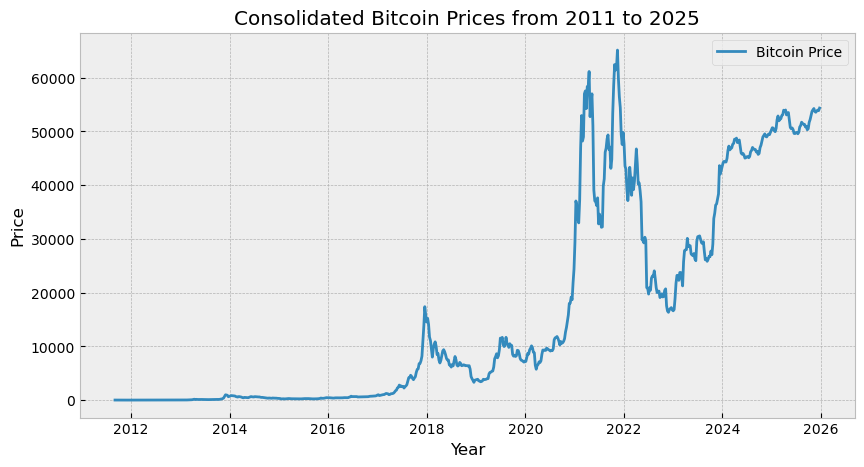

In [86]:
print(df_combined.head())
print(df_combined.tail())

# Optionally, plot the results to visually inspect the continuity and correctness
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_combined.index, df_combined['Price'], label='Bitcoin Price')
plt.title('Consolidated Bitcoin Prices from 2011 to 2025')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()


In [87]:
df_combined_1 = pd.DataFrame(df_combined)
df_combined_1 

,Price
2011-09-04,8.562000
2011-09-11,6.644000
2011-09-18,5.432000
2011-09-25,5.632000
2011-10-02,4.896000
...,...
2025-11-23,53572.418001
2025-11-30,53809.770140
2025-12-07,53979.706362
2025-12-14,53876.773545


In [88]:
df_combined_1['SMA1'] = df_combined_1['Price'].rolling(10).mean()
df_combined_1['SMA2'] = df_combined_1['Price'].rolling(60).mean()
df_combined_1.tail()

,Price,SMA1,SMA2
2025-11-23,53572.418001,52704.957709,51128.372231
2025-11-30,53809.770140,53054.352210,51241.931435
2025-12-07,53979.706362,53401.170967,51350.686387
2025-12-14,53876.773545,53619.070131,51445.284119
2025-12-21,54354.375599,53833.295107,51534.845606


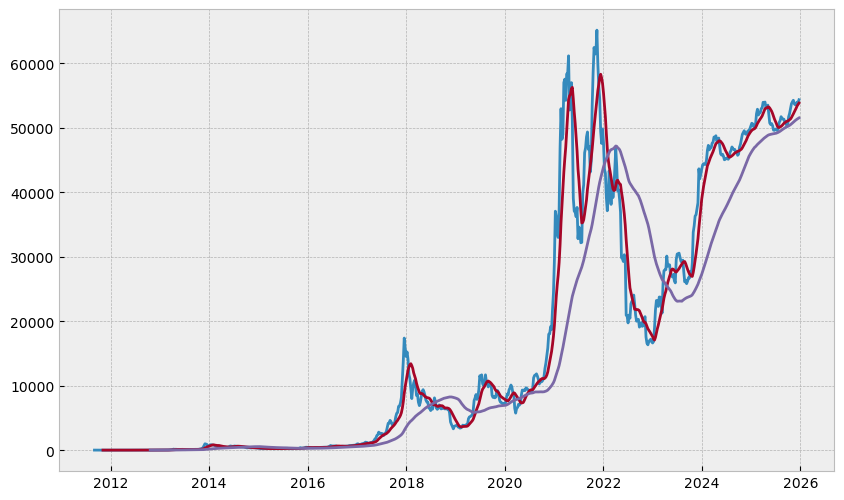

In [89]:
plt.figure(figsize = (10,6))
plt.plot(df_combined_1)
plt.show()

<AxesSubplot:title={'center':'SMA Signal'}>

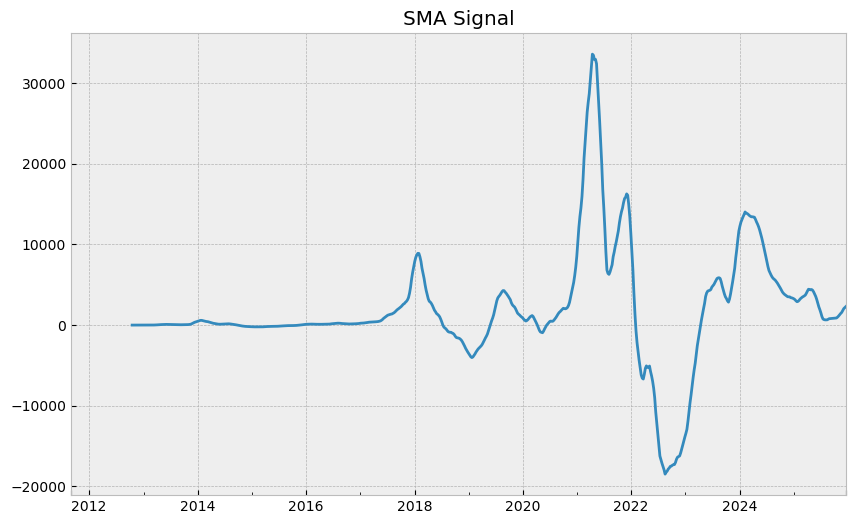

In [90]:
df_combined_1['signal'] = df_combined_1['SMA1'] - df_combined_1['SMA2']
df_combined_1['signal'].plot(figsize=(10, 6),
                    title='SMA Signal')

In [91]:
df_combined_1['position'] = np.sign(df_combined_1['signal'])
df_combined_1.tail()

,Price,SMA1,SMA2,signal,position
2025-11-23,53572.418001,52704.957709,51128.372231,1576.585478,1.0
2025-11-30,53809.770140,53054.352210,51241.931435,1812.420775,1.0
2025-12-07,53979.706362,53401.170967,51350.686387,2050.484580,1.0
2025-12-14,53876.773545,53619.070131,51445.284119,2173.786011,1.0
2025-12-21,54354.375599,53833.295107,51534.845606,2298.449500,1.0


In [92]:
df_combined_1['position'].value_counts()

 1.0    512
-1.0    176
Name: position, dtype: int64

In [94]:
df_combined_1['future_returns'] = np.log(df_combined_1['Price'].shift(-1) / df_combined_1['Price'])
df_combined_1.tail()

,Price,SMA1,SMA2,signal,position,future_returns
2025-11-23,53572.418001,52704.957709,51128.372231,1576.585478,1.0,0.004421
2025-11-30,53809.770140,53054.352210,51241.931435,1812.420775,1.0,0.003153
2025-12-07,53979.706362,53401.170967,51350.686387,2050.484580,1.0,-0.001909
2025-12-14,53876.773545,53619.070131,51445.284119,2173.786011,1.0,0.008826
2025-12-21,54354.375599,53833.295107,51534.845606,2298.449500,1.0,NaN


In [95]:
df_combined_1['strategy'] = df_combined_1['position'] * df_combined_1['future_returns']
df_combined_1.tail()

,Price,SMA1,SMA2,signal,position,future_returns,strategy
2025-11-23,53572.418001,52704.957709,51128.372231,1576.585478,1.0,0.004421,0.004421
2025-11-30,53809.770140,53054.352210,51241.931435,1812.420775,1.0,0.003153,0.003153
2025-12-07,53979.706362,53401.170967,51350.686387,2050.484580,1.0,-0.001909,-0.001909
2025-12-14,53876.773545,53619.070131,51445.284119,2173.786011,1.0,0.008826,0.008826
2025-12-21,54354.375599,53833.295107,51534.845606,2298.449500,1.0,NaN,NaN
